# Using ventricle project model to predict skull stripped



In [1]:
import sys
sys.path.append('../src/')

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from unet import eval_preds

from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

from pathlib import Path
from torch import FloatTensor as FT

torch.cuda.set_device(0)

#  load images

In [5]:
# Read images
data_path = Path("/data/public/MIM_BMETS_V6/3_images_masks_for_training/20191125/")
trn_img = sorted(list(Path(data_path/"training/images").iterdir()))
trn_mask = sorted(list(Path(data_path/"training/brain_masks").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/images").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/brain_masks").iterdir()))
test_img = sorted(list(Path(data_path/"testing/images").iterdir()))
test_mask = sorted(list(Path(data_path/"testing/brain_masks").iterdir()))


print(f"Size of Train Dataset Images: {len(trn_img)} Images")
print(f"Size of Validation Dataset Images: {len(valid_img)} Images")
print(f"Size of Train Dataset Masks: {len(trn_mask)} Images")
print(f"Size of Validation Dataset Masks: {len(valid_mask)} Images")
print(f"Size of Test 1 Dataset Images: {len(test1_img)} Images")
print(f"Size of Test 1 Dataset Masks: {len(test1_mask)} Images")

Size of Train Dataset Images: 270 Images
Size of Validation Dataset Images: 35 Images
Size of Train Dataset Masks: 270 Images
Size of Validation Dataset Masks: 35 Images
Size of Test 1 Dataset Images: 35 Images
Size of Test 1 Dataset Masks: 35 Images


In [6]:
class MR_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)

train_ds = MR_3D_Dataset(trn_img, trn_mask)
valid_ds = MR_3D_Dataset(valid_img, valid_mask)   
test_ds = MR_3D_Dataset(test_img, test_mask)

bs=1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=1)
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size=bs), device=data.device)

# load baseline 11 model (3D Residual UNet)

In [7]:
# Load model baseline11
model_name = 'baseline11'
f = experiment_model_dict[model_name]
m = f()

loss_func = 'dice'
model_dir = '/home/nanot/MEDomicsLab-develop-ventproject-new/Final_Scripts/models/tl_brain_mr_models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_TL_Brain_MR_Baseline_11');

In [8]:
# get test1 predictions
learn.to_fp32();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

test_preds, test_targs = get_preds_targs(test_dl)
baseline11_preds = test_preds
baseline11_masks = test_targs

print(learn.validate(test_dl))

[0.040736593, tensor(0.9593)]


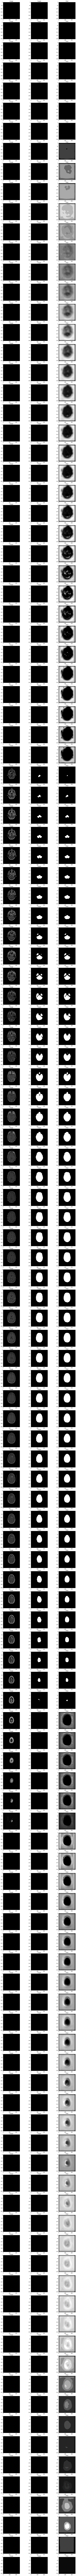

In [72]:
IMG_SET = 6
brainimgs = test_ds.__getitem__(IMG_SET)
#fig, ax = plt.subplots(55,2,figsize=(20,20))
#fig.set_size_inches(15,150)
plt.figure(figsize=(15, 500))
c = 1
for i in range(0,128):
    plt.subplot(128, 3, c)
    plt.imshow(128 + 128*brainimgs[0][0][i,:,:], cmap="gray")
    plt.title('Image')
    c = c + 1
    plt.subplot(128, 3, c)
    plt.imshow(128 + 128*test_targs[IMG_SET][i,:,:], cmap="gray")
    plt.title('Target')
    c = c + 1
    plt.subplot(128, 3, c)
    plt.imshow(128 + 128*baseline11_preds[IMG_SET][i,:,:], cmap="gray")
    plt.title('Pred')
    c = c + 1
    #ImageSegment(128 + 128*brainimgs[0][0][40+i][None,...]).show(ax=ax[i,0], alpha=1, cmap='gray', title='Image')#('Image %i' %i))
    #ImageSegment(test_targs[IMG_SET][40+i][None,...]).show(ax=ax[i,0], alpha=1, cmap='gray', title='Target')
    #ImageSegment(baseline11_preds[IMG_SET][40+i][None,...]).show(ax=ax[i,1], alpha=1, cmap='gray', title='Baseline 11')

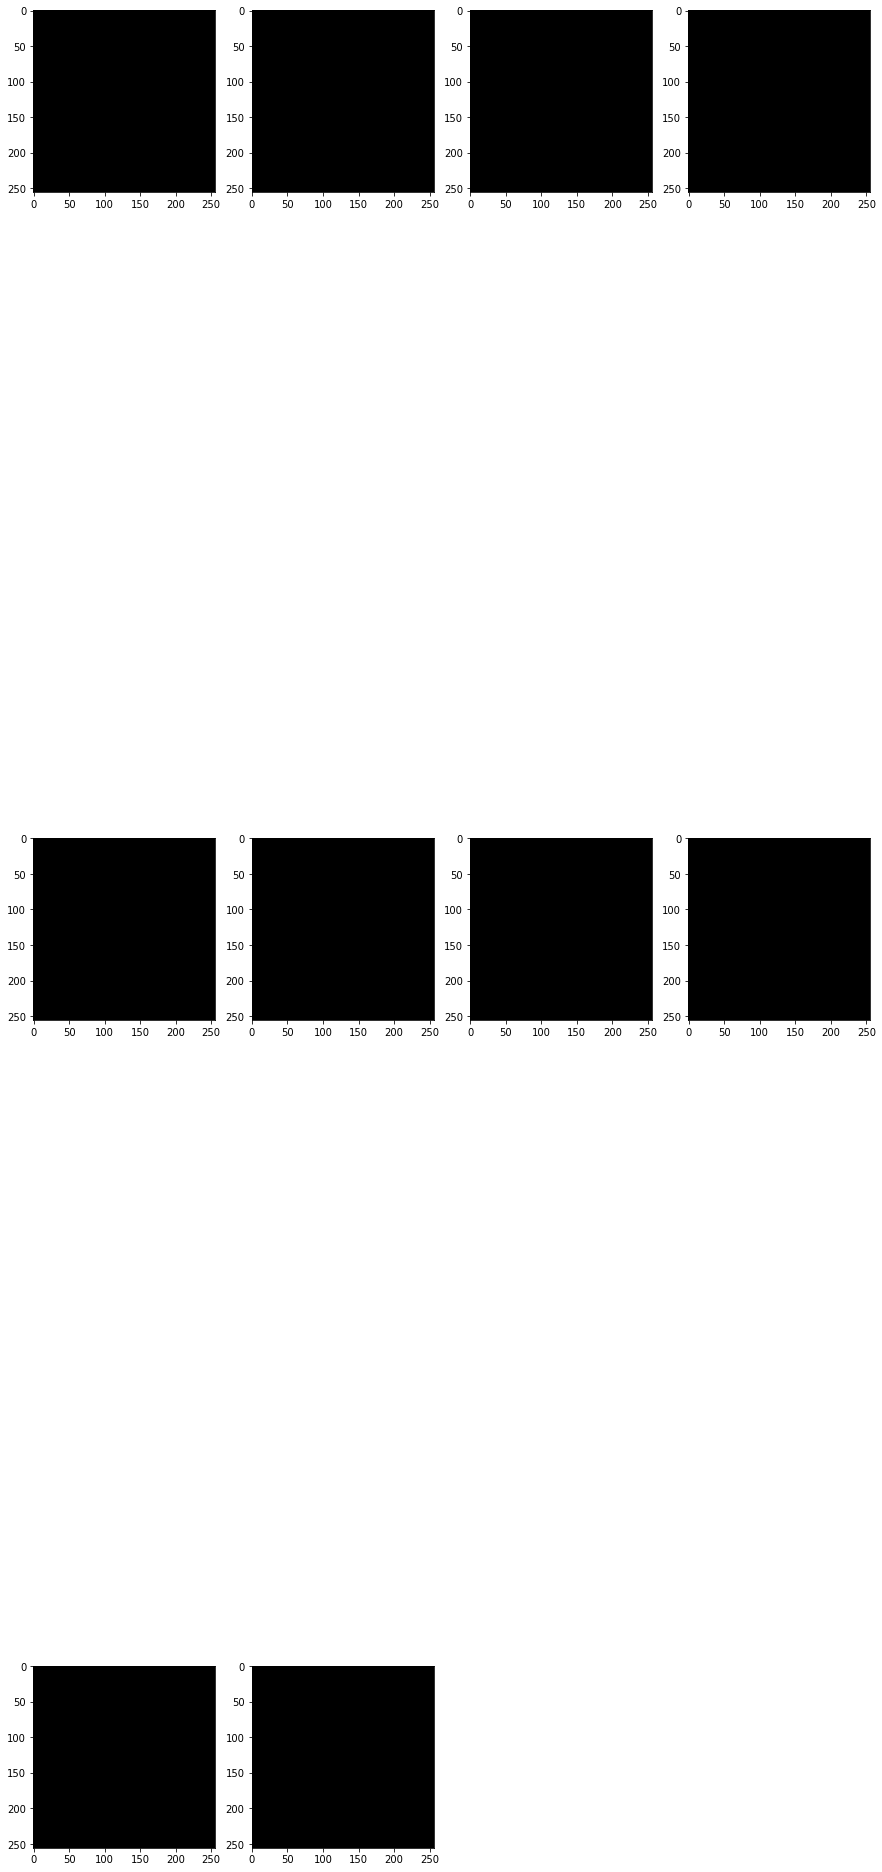

In [62]:
brainimgs = test_ds.__getitem__(IMG_SET)
#fig, ax = plt.subplots(55,1,figsize=(20,20))
#fig.set_size_inches(15,150)
plt.figure(figsize=(15, 500))
for i in range(0,):
    plt.subplot(round(128/4) + 1, 4, i+1)
    plt.imshow(brainimgs[0][0][i,:,:], cmap="gray")
    #ImageSegment(brainimgs[0][0][i,:,:]).show(ax=ax[i])#('Image %i' %i))


In [61]:
len(brainimgs[0][0][:,1,1])

128

# Generate table and figures

In [54]:
def summary_table(target_masks, pred_masks, file_names):
    pred_dice_scores = [dice_score(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    pred_percent_vol_diff = [vol_perc_diff(target_masks[i], pred_masks[i], True)*100 for i in range(len(target_masks))]
    d = {'test_name': file_names,
         'pred_dice_scores': pred_dice_scores, 
         'pred_percent_vol_diff': pred_percent_vol_diff}
    df = pd.DataFrame(data=d)
    return df

def vol_perc_diff(mask, pred, absolute=False):
    mask_vol = (((mask.numpy()).sum()).sum()).sum()
    pred_vol = (((pred.numpy()).sum()).sum()).sum()
    if not absolute:
        return (pred_vol-mask_vol)/mask_vol
    return abs(pred_vol-mask_vol)/mask_vol

def dice_score(target, preds, thresh=0.5):
    iT = target.numpy()
    iP = preds.numpy()
    intersection = (((iT * iP).sum()).sum()).sum()
    return ((2.0 * intersection) / (((iT.sum()).sum()).sum() + ((iP.sum()).sum()).sum() + 1e-6))

In [57]:
pred_masks = baseline11_preds
target_masks = baseline11_masks

names = []
data_path = data_path = Path("/data/public/MIM_BMETS_V6/3_images_masks_for_training/20191125/")
test1_img_files = sorted(list(Path(data_path/"testing/images").iterdir()))
ok_names = [o.name for o in test1_img_files]
file_names = [fn for fn in test1_img_files if fn.name in ok_names]
for i in range(len(file_names)):
    names.append(str(file_names[i]).split("/")[-1].split("_")[0])


df = summary_table(target_masks, pred_masks, names)
df_summary = df.describe()

baseline11_mean_d = df_summary.iloc[1]['pred_dice_scores'] # mean
baseline11_std_d = df_summary.iloc[2]['pred_dice_scores'] # std
baseline11_mean_p = df_summary.iloc[1]['pred_percent_vol_diff'] # mean
baseline11_std_p = df_summary.iloc[2]['pred_percent_vol_diff'] # std

df

,test_name,pred_dice_scores,pred_percent_vol_diff
0,BrainMets-UCSF-00045,0.962493,2.853820
1,BrainMets-UCSF-00051,0.973101,2.780665
2,BrainMets-UCSF-00135,0.956711,6.515117
3,BrainMets-UCSF-00155,0.964251,5.062480
4,BrainMets-UCSF-00164,0.970899,1.975558
5,BrainMets-UCSF-00171,0.968494,3.647810
6,BrainMets-UCSF-00211,0.977491,1.366170
7,BrainMets-UCSF-00240,0.964842,4.766877
8,BrainMets-UCSF-00298,0.957809,6.115421
9,BrainMets-UCSF-00325,0.960123,4.157207


In [59]:
df_summary

,pred_dice_scores,pred_percent_vol_diff
count,35.000000,35.000000
mean,0.959264,5.024810
std,0.017060,3.798458
min,0.896579,0.614616
25%,0.957424,2.785990
50%,0.963526,4.279000
75%,0.967931,6.100131
max,0.977491,18.318066
